In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os

In [2]:
from keras.layers import Conv2D, Conv2DTranspose, Input,Dropout, ReLU,BatchNormalization,Concatenate,LeakyReLU,Identity
from keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

2024-07-25 12:00:38.445573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
!wget -nc https://github.com/Sxela/face2comics/releases/download/v2.0.0/face2comics_v2.0.0_by_Sxela_faces.tar
!tar --skip-old-files -xf face2comics_v2.0.0_by_Sxela_faces.tar

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
File ‘face2comics_v2.0.0_by_Sxela_faces.tar’ already there; not retrieving.

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
tar: A lone zero block at 2696643


In [4]:
!wget -nc https://github.com/Sxela/face2comics/releases/download/v2.0.0/face2comics_v2.0.0_by_Sxela_comics.tar
!tar --skip-old-files -xf face2comics_v2.0.0_by_Sxela_comics.tar

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
File ‘face2comics_v2.0.0_by_Sxela_comics.tar’ already there; not retrieving.

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
tar: A lone zero block at 1904148


In [5]:
y_folder = "comics"
x_folder = "faces"

In [6]:
x_files = sorted([os.path.join(x_folder, fname) for fname in os.listdir(x_folder) if fname.endswith(".jpg")])
y_files = sorted([os.path.join(y_folder, fname) for fname in os.listdir(y_folder) if fname.endswith(".jpg")])

assert len(x_files) == len(y_files), "Number of files in each folder must be the same"

In [7]:
img_size = 128

In [8]:
# Function to load and preprocess images
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_size, img_size])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

# Function to load and preprocess paired images
def load_pair(x_path, y_path):
    x_image = load_image(x_path)
    y_image = load_image(y_path)
    return x_image, y_image

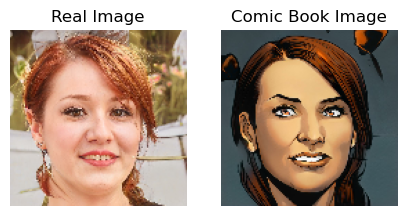

In [38]:
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow((load_image(x_files[0]) +1)/2)
plt.title("Real Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow((load_image(y_files[0]) +1)/2)
plt.title("Comic Book Image")
plt.axis('off')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(x_files, y_files, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.125, random_state=42)

len(X_train),len(X_val),len(X_test)

(7000, 1000, 2000)

In [12]:
def create_dataset(x_files, y_files,batch_size=8,is_train=False):
    # Create a TensorFlow dataset from the file paths
    dataset = tf.data.Dataset.from_tensor_slices((x_files, y_files))

    # Map the file paths to images
    dataset = dataset.map(lambda x, y: tf.py_function(load_pair, [x, y], [tf.float32, tf.float32]))

    if is_train: dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_train, Y_train,is_train=True)
test_dataset = create_dataset(X_test, Y_test)
val_dataset = create_dataset(X_val, Y_val)

In [13]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [14]:
def CK(filters, kernel_size=(4, 4), strides=(2, 2), padding='same', use_batch_norm=True, downsample=True):
    conv = Conv2D               if downsample       else Conv2DTranspose
    norm = BatchNormalization   if use_batch_norm   else Identity
    actf = LeakyReLU(0.2)       if downsample       else ReLU()

    def layer(x):
        x = conv(filters, kernel_size, strides=strides, padding=padding)(x)
        x = norm()(x)
        x = actf(x)
        return x
    return layer

def CDK(filters, kernel_size=(4, 4), strides=(2, 2), padding='same', use_batch_norm=True, downsample=True,dropout_rate=0.5):
    conv = Conv2D               if downsample       else Conv2DTranspose
    norm = BatchNormalization   if use_batch_norm   else Identity
    actf = ReLU()

    def layer(x):
        x = conv(filters, kernel_size, strides=strides, padding=padding)(x)
        x = norm()(x)
        x = Dropout(dropout_rate)(x)
        x = actf(x)
        return x
    return layer


In [15]:
def generator(input_nc, output_nc, ngf, num_blocks=1, num_downsample=3):
    inputs = Input(shape=(img_size, img_size, input_nc))
    x = inputs

    # Initial convolutional layers
    x = CK(ngf,use_batch_norm=False)(x)

    # Contracting path
    skips = []
    for i in range(num_downsample + num_blocks - 1):
        expo = min(i+1,num_downsample)
        x = CK(ngf*(2**(expo)))(x)
        skips.append(x)

    skips = list(reversed(skips))
    for skip in skips[:num_blocks-1]:
        x = Concatenate()([x, skip])
        x = CDK(ngf*(2**(num_downsample)),downsample=False)(x)

    for skip in skips[num_blocks-1:]:
        x = Concatenate()([x, skip])
        x = CK(ngf * (2 ** i),downsample=False)(x)

    output = Conv2DTranspose(output_nc, (4, 4), activation='tanh',padding="same",strides=(2, 2))(x)
    return Model(inputs=inputs, outputs=output)

In [16]:
def discriminator(input_nc,output_nc, ngf, num_blocks=1, num_downsample=3):

    inp = Input(shape=[img_size, img_size, input_nc], name='input_image')
    tar = Input(shape=[img_size, img_size, output_nc], name='target_image')

    x = Concatenate()([inp, tar])

    # Initial convolutional layers
    x = CK(ngf,use_batch_norm=False)(x)

    # Contracting path
    for i in range(num_downsample):
        x = CK(ngf*(2**(i+1)))(x)

    output = Conv2D(1, (4, 4), activation='sigmoid',padding="same",strides=(2, 2))(x)
    return Model(inputs=[inp, tar], outputs=output)

In [17]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [18]:
def discriminator_loss(real_output, fake_output):
    cross_entropy = BinaryCrossentropy(from_logits=False)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    cross_entropy = BinaryCrossentropy(from_logits=False)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def l1_loss(real_image, generated_image):
    return tf.reduce_mean(tf.abs(real_image - generated_image))

In [19]:
generator_optimizer = Adam(2e-4, beta_1=0.5,beta_2=0.999)
discriminator_optimizer = Adam(2e-4, beta_1=0.5,beta_2=0.999)
LAMBDA = 100


@tf.function
def train_step(input_image, target_image, generator, discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(input_image, training=True)

        real_output = discriminator([input_image, target_image], training=True)
        fake_output = discriminator([input_image, generated_image], training=True)

        gen_loss = generator_loss(fake_output) + LAMBDA*l1_loss(target_image, generated_image)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [20]:
def evaluate_model(validation_dataset, generator_model, discriminator_model):
    # Initialize accumulators for metrics
    val_gen_loss_total = 0
    val_rmse_total = 0
    num_batches = 0

    # Iterate over the validation dataset
    for batch in validation_dataset:
        input_image, target_image = batch

        # Generate images using the generator model
        generated_image = generator_model(input_image, training=False)

        # Compute losses
        val_gen_loss = generator_loss(discriminator_model([input_image, target_image], training=False)) + l1_loss(target_image, generated_image)
        val_rmse = rmse(target_image, generated_image)

        # Accumulate metrics
        val_gen_loss_total += val_gen_loss
        val_rmse_total += val_rmse
        num_batches += 1

    # Compute average metrics
    avg_val_gen_loss = val_gen_loss_total / num_batches
    avg_val_rmse = val_rmse_total / num_batches

    return avg_val_gen_loss, avg_val_rmse

In [21]:
# Example usage
input_nc = 3  # Number of input channels (e.g., RGB)
output_nc = 3  # Number of output channels (e.g., RGB)
ngf = 64  # Number of generator filters in first conv layer

generator_model     = generator(input_nc, output_nc, ngf, num_blocks=3, num_downsample=4)
discriminator_model = discriminator(input_nc,output_nc, ngf, num_blocks=3, num_downsample=4)

generator_model.compile(optimizer=generator_optimizer, loss=generator_loss)
discriminator_model.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)

In [22]:
generator_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           3136      ['input_1[0][0]']             
                                                                                                  
 identity (Identity)         (None, 64, 64, 64)           0         ['conv2d[0][0]']              
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)           0         ['identity[0][0]']            
                                                                                              

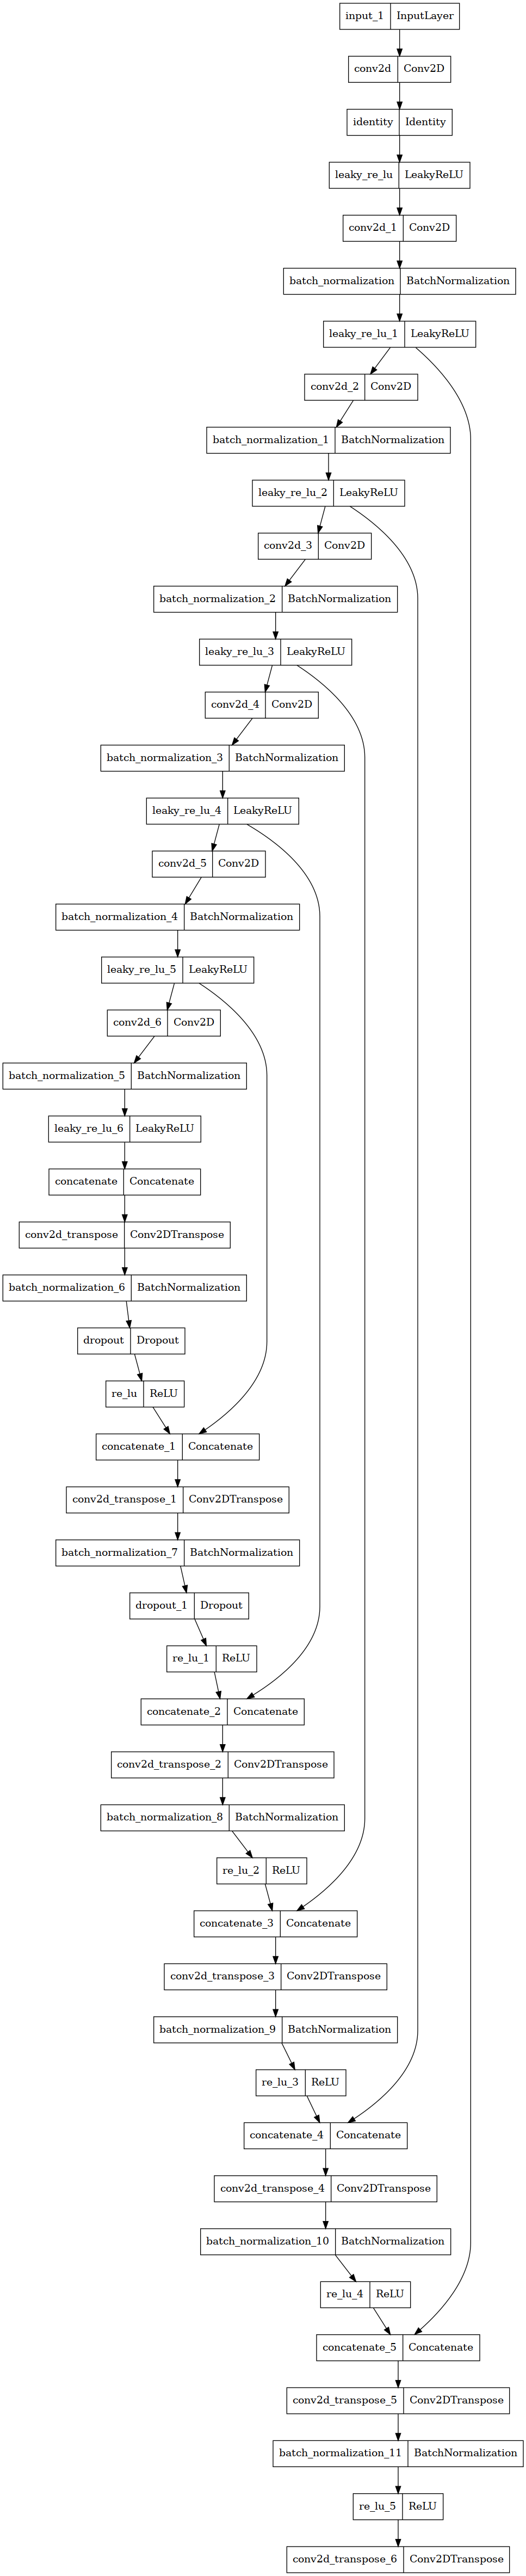

In [23]:
plot_model(generator_model)

In [24]:
discriminator_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 concatenate_6 (Concatenate  (None, 128, 128, 6)          0         ['input_image[0][0]',         
 )                                                                   'target_image[0][0]']        
                                                                                                  
 conv2d_7 (Conv2D)           (None, 64, 64, 64)           6208      ['concatenate_6[0][0]'] 

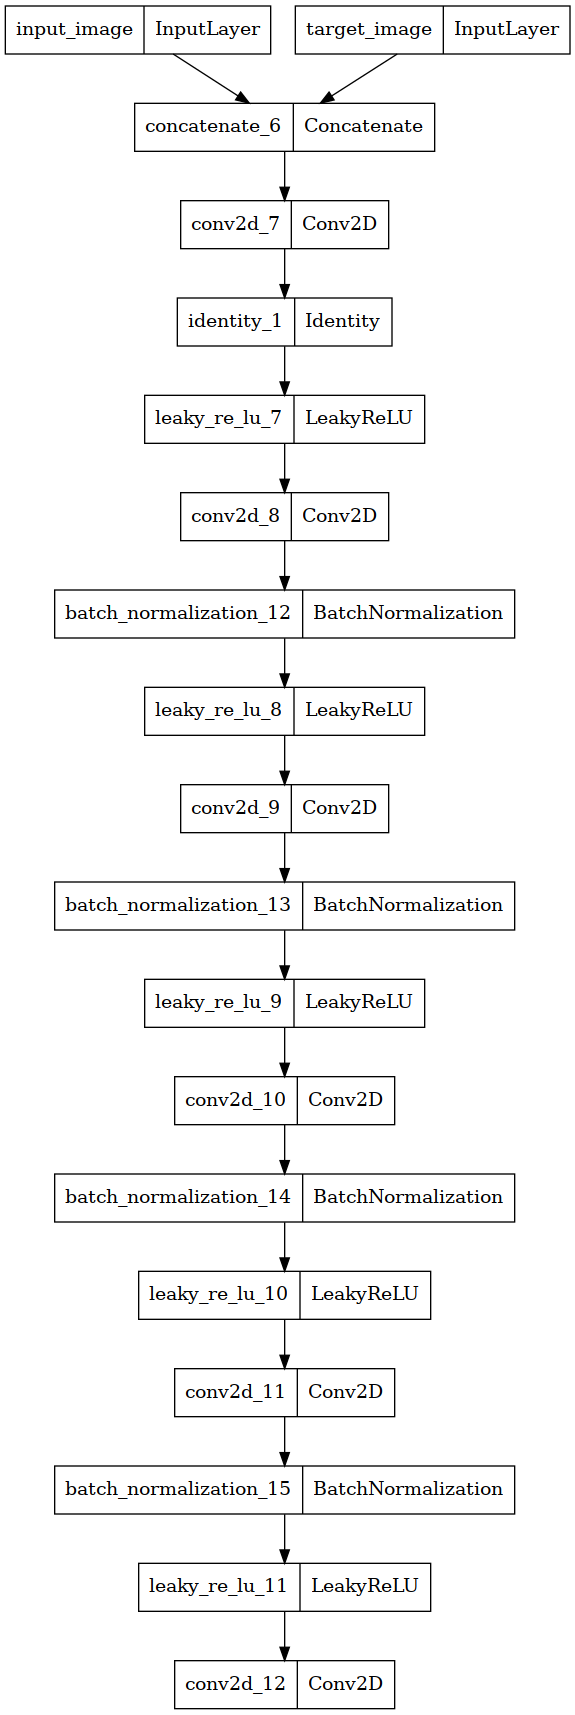

In [25]:
plot_model(discriminator_model)

In [26]:
# Lists to store metrics
epochs_list = []
gen_losses = []
disc_losses = []
val_gen_losses = []
val_rmses = []
val_psnrs = []

In [27]:
# Training loop
epochs = 200
for epoch in range(epochs):
    gen_loss_total = 0
    disc_loss_total = 0
    num_batches = 0

    for batch in train_dataset:
        input_image, target_image = batch
        gen_loss, disc_loss = train_step(input_image, target_image, generator_model, discriminator_model)

        # Accumulate training losses
        gen_loss_total += gen_loss.numpy().item()
        disc_loss_total += disc_loss.numpy().item()
        num_batches += 1

    val_gen_loss, val_rmse = evaluate_model(val_dataset, generator_model, discriminator_model)

    # Compute average training losses
    gen_loss = gen_loss_total / num_batches
    disc_loss = disc_loss_total / num_batches

    # Collect training losses
    epochs_list.append(epoch + 1)
    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)

    val_gen_losses.append(val_gen_loss.numpy().item())
    val_rmses.append(val_rmse.numpy().item())

    print(f"Epoch {epoch+1}/{epochs} - Gen Loss: {gen_loss:.4f}, D Loss: {disc_loss:.4f}")
    # Validation step
    print(f"Val Gen Loss: {val_gen_loss.numpy().item():.4f}, RMSE: {val_rmse.numpy().item():.4f}")
    print()

2024-07-25 12:00:59.113873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 808 of 1000
2024-07-25 12:01:01.608247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2024-07-25 12:01:05.186466: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-07-25 12:01:05.764448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-07-25 12:01:10.462046: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x77fc2835e270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-25 12:01:10.462085: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-07-25 1

Epoch 1/200 - Gen Loss: 30.3387, D Loss: 0.4464
Val Gen Loss: 2.9092, RMSE: 0.5241



2024-07-25 12:09:59.652226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 799 of 1000
2024-07-25 12:10:02.153232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 2/200 - Gen Loss: 31.3714, D Loss: 0.1939
Val Gen Loss: 3.5382, RMSE: 0.4620



2024-07-25 12:18:26.914573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 668 of 1000
2024-07-25 12:18:31.851166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 3/200 - Gen Loss: 27.4595, D Loss: 0.7618
Val Gen Loss: 1.5845, RMSE: 0.3577



2024-07-25 12:27:03.839419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 817 of 1000
2024-07-25 12:27:06.129212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 4/200 - Gen Loss: 25.5461, D Loss: 0.8709
Val Gen Loss: 1.0510, RMSE: 0.3602



2024-07-25 12:35:31.355436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 773 of 1000
2024-07-25 12:35:34.213987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 5/200 - Gen Loss: 24.8349, D Loss: 0.8949
Val Gen Loss: 1.0934, RMSE: 0.3709



2024-07-25 12:44:09.949525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 811 of 1000
2024-07-25 12:44:12.345131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 6/200 - Gen Loss: 24.1846, D Loss: 0.8755
Val Gen Loss: 0.4919, RMSE: 0.3648



2024-07-25 12:52:51.909683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 803 of 1000
2024-07-25 12:52:54.512427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 7/200 - Gen Loss: 23.5256, D Loss: 0.8491
Val Gen Loss: 0.8769, RMSE: 0.3482



2024-07-25 13:01:11.764818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 849 of 1000
2024-07-25 13:01:13.611651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 8/200 - Gen Loss: 22.9028, D Loss: 0.8476
Val Gen Loss: 0.6091, RMSE: 0.3512



2024-07-25 13:09:33.822625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 853 of 1000
2024-07-25 13:09:35.520010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 9/200 - Gen Loss: 22.3523, D Loss: 0.8157
Val Gen Loss: 1.3345, RMSE: 0.3512



2024-07-25 13:17:54.649117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 854 of 1000
2024-07-25 13:17:56.401155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 10/200 - Gen Loss: 22.0379, D Loss: 0.7834
Val Gen Loss: 0.9118, RMSE: 0.3338



2024-07-25 13:26:21.206150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 846 of 1000
2024-07-25 13:26:23.029083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 11/200 - Gen Loss: 21.7345, D Loss: 0.7449
Val Gen Loss: 0.7318, RMSE: 0.3290



2024-07-25 13:34:49.070812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 871 of 1000
2024-07-25 13:34:50.547892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 12/200 - Gen Loss: 21.4026, D Loss: 0.7006
Val Gen Loss: 0.5819, RMSE: 0.3316



2024-07-25 13:43:15.796593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 878 of 1000
2024-07-25 13:43:17.224165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 13/200 - Gen Loss: 21.1119, D Loss: 0.6882
Val Gen Loss: 0.5074, RMSE: 0.3236



2024-07-25 13:51:43.011333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 883 of 1000
2024-07-25 13:51:44.441918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 14/200 - Gen Loss: 20.9408, D Loss: 0.6542
Val Gen Loss: 1.5725, RMSE: 0.3414



2024-07-25 14:00:09.852909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 866 of 1000
2024-07-25 14:00:11.447283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 15/200 - Gen Loss: 20.6837, D Loss: 0.6441
Val Gen Loss: 1.0198, RMSE: 0.3236



2024-07-25 14:08:36.609411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 895 of 1000
2024-07-25 14:08:37.788507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 16/200 - Gen Loss: 20.4214, D Loss: 0.6227
Val Gen Loss: 0.7050, RMSE: 0.3234



2024-07-25 14:17:00.607114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 846 of 1000
2024-07-25 14:17:02.575230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 17/200 - Gen Loss: 20.3252, D Loss: 0.6018
Val Gen Loss: 1.2695, RMSE: 0.3275



2024-07-25 14:25:29.219574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 859 of 1000
2024-07-25 14:25:30.901606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 18/200 - Gen Loss: 20.1877, D Loss: 0.5894
Val Gen Loss: 0.8752, RMSE: 0.3241



2024-07-25 14:33:54.356837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 875 of 1000
2024-07-25 14:33:55.884576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 19/200 - Gen Loss: 19.9536, D Loss: 0.5875
Val Gen Loss: 1.1506, RMSE: 0.3189



2024-07-25 14:42:20.807845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 742 of 1000
2024-07-25 14:42:24.111436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 20/200 - Gen Loss: 19.8338, D Loss: 0.5501
Val Gen Loss: 1.0020, RMSE: 0.3192



2024-07-25 14:50:47.249301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 871 of 1000
2024-07-25 14:50:48.801395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 21/200 - Gen Loss: 19.7644, D Loss: 0.5456
Val Gen Loss: 1.0189, RMSE: 0.3249



2024-07-25 14:59:12.656217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 845 of 1000
2024-07-25 14:59:14.490649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 22/200 - Gen Loss: 19.6581, D Loss: 0.5505
Val Gen Loss: 0.9328, RMSE: 0.3215



2024-07-25 15:07:42.305984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 856 of 1000
2024-07-25 15:07:44.195746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 23/200 - Gen Loss: 19.6388, D Loss: 0.5045
Val Gen Loss: 0.8440, RMSE: 0.3250



2024-07-25 15:16:09.126200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 862 of 1000
2024-07-25 15:16:10.747788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 24/200 - Gen Loss: 19.6055, D Loss: 0.4763
Val Gen Loss: 1.5337, RMSE: 0.3239



2024-07-25 15:24:32.404909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 878 of 1000
2024-07-25 15:24:33.829192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 25/200 - Gen Loss: 19.6858, D Loss: 0.4858
Val Gen Loss: 1.5525, RMSE: 0.3240



2024-07-25 15:32:57.735307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 876 of 1000
2024-07-25 15:32:59.070854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 26/200 - Gen Loss: 19.4173, D Loss: 0.5077
Val Gen Loss: 1.0424, RMSE: 0.3178



2024-07-25 15:41:22.486787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 898 of 1000
2024-07-25 15:41:23.661065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 27/200 - Gen Loss: 20.2644, D Loss: 0.4145
Val Gen Loss: 0.7659, RMSE: 0.3239



2024-07-25 15:49:47.609470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 854 of 1000
2024-07-25 15:49:49.674484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 28/200 - Gen Loss: 19.5833, D Loss: 0.4835
Val Gen Loss: 0.9597, RMSE: 0.3175



2024-07-25 15:58:13.102558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 879 of 1000
2024-07-25 15:58:14.553481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 29/200 - Gen Loss: 19.3140, D Loss: 0.4423
Val Gen Loss: 1.4872, RMSE: 0.3149



2024-07-25 16:06:38.086235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 878 of 1000
2024-07-25 16:06:39.493428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 30/200 - Gen Loss: 19.1337, D Loss: 0.4685
Val Gen Loss: 1.3345, RMSE: 0.3166



2024-07-25 16:15:05.031708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 893 of 1000
2024-07-25 16:15:06.244997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 31/200 - Gen Loss: 19.1871, D Loss: 0.4494
Val Gen Loss: 1.1104, RMSE: 0.3182



2024-07-25 16:23:32.876533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 877 of 1000
2024-07-25 16:23:34.368122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 32/200 - Gen Loss: 19.3022, D Loss: 0.3919
Val Gen Loss: 1.0389, RMSE: 0.3169



2024-07-25 16:31:58.366423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 863 of 1000
2024-07-25 16:32:00.004426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 33/200 - Gen Loss: 19.4001, D Loss: 0.4053
Val Gen Loss: 1.3047, RMSE: 0.3148



2024-07-25 16:40:26.568654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 872 of 1000
2024-07-25 16:40:28.115576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 34/200 - Gen Loss: 19.2607, D Loss: 0.4280
Val Gen Loss: 0.9282, RMSE: 0.3155



2024-07-25 16:48:51.924207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 903 of 1000
2024-07-25 16:48:52.987294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 35/200 - Gen Loss: 19.1221, D Loss: 0.4308
Val Gen Loss: 1.0269, RMSE: 0.3107



2024-07-25 16:57:15.760614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 851 of 1000
2024-07-25 16:57:17.636735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 36/200 - Gen Loss: 19.1009, D Loss: 0.3843
Val Gen Loss: 1.2046, RMSE: 0.3137



2024-07-25 17:05:43.355433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 865 of 1000
2024-07-25 17:05:45.031865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 37/200 - Gen Loss: 18.9556, D Loss: 0.4159
Val Gen Loss: 1.0924, RMSE: 0.3184



2024-07-25 17:14:10.811274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 885 of 1000
2024-07-25 17:14:12.223172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 38/200 - Gen Loss: 18.9238, D Loss: 0.4186
Val Gen Loss: 1.7603, RMSE: 0.3088



2024-07-25 17:22:37.660042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 895 of 1000
2024-07-25 17:22:38.838057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 39/200 - Gen Loss: 18.9742, D Loss: 0.3613
Val Gen Loss: 1.6305, RMSE: 0.3149



2024-07-25 17:31:02.519943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 904 of 1000
2024-07-25 17:31:03.688822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 40/200 - Gen Loss: 18.9471, D Loss: 0.3812
Val Gen Loss: 1.4987, RMSE: 0.3140



2024-07-25 17:39:29.562667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 761 of 1000
2024-07-25 17:39:33.345940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 41/200 - Gen Loss: 18.8787, D Loss: 0.3816
Val Gen Loss: 1.2548, RMSE: 0.3120



2024-07-25 17:47:56.766150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 884 of 1000
2024-07-25 17:47:58.126200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 42/200 - Gen Loss: 18.9033, D Loss: 0.3680
Val Gen Loss: 0.9442, RMSE: 0.3108



2024-07-25 17:56:23.686276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 845 of 1000
2024-07-25 17:56:26.137558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 43/200 - Gen Loss: 18.7373, D Loss: 0.4050
Val Gen Loss: 2.0078, RMSE: 0.3082



2024-07-25 18:04:49.318790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 913 of 1000
2024-07-25 18:04:50.330712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 44/200 - Gen Loss: 18.6143, D Loss: 0.3537
Val Gen Loss: 1.3219, RMSE: 0.3103



2024-07-25 18:13:13.779126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 889 of 1000
2024-07-25 18:13:15.069738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 45/200 - Gen Loss: 18.5347, D Loss: 0.3885
Val Gen Loss: 1.1961, RMSE: 0.3105



2024-07-25 18:21:38.882493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 876 of 1000
2024-07-25 18:21:40.348953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 46/200 - Gen Loss: 18.5691, D Loss: 0.3648
Val Gen Loss: 1.5190, RMSE: 0.3076



2024-07-25 18:30:02.030220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 871 of 1000
2024-07-25 18:30:03.518809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 47/200 - Gen Loss: 18.4824, D Loss: 0.3624
Val Gen Loss: 1.7935, RMSE: 0.3104



2024-07-25 18:38:26.739635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 882 of 1000
2024-07-25 18:38:28.088944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 48/200 - Gen Loss: 18.7242, D Loss: 0.3292
Val Gen Loss: 1.6526, RMSE: 0.3106



2024-07-25 18:46:51.860908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 869 of 1000
2024-07-25 18:46:53.382684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 49/200 - Gen Loss: 18.3169, D Loss: 0.3796
Val Gen Loss: 2.2002, RMSE: 0.3114



2024-07-25 18:55:18.779377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 858 of 1000
2024-07-25 18:55:20.480363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 50/200 - Gen Loss: 18.4650, D Loss: 0.3494
Val Gen Loss: 2.2905, RMSE: 0.3065



2024-07-25 19:03:43.554662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 854 of 1000
2024-07-25 19:03:45.347748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 51/200 - Gen Loss: 18.2981, D Loss: 0.3736
Val Gen Loss: 2.0077, RMSE: 0.3074



2024-07-25 19:12:10.037863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 792 of 1000
2024-07-25 19:12:13.588037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 52/200 - Gen Loss: 18.3342, D Loss: 0.3279
Val Gen Loss: 1.7825, RMSE: 0.3092



2024-07-25 19:20:35.494830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 878 of 1000
2024-07-25 19:20:36.900707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 53/200 - Gen Loss: 18.2279, D Loss: 0.3598
Val Gen Loss: 2.3852, RMSE: 0.3074



2024-07-25 19:29:02.267277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 884 of 1000
2024-07-25 19:29:03.663056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 54/200 - Gen Loss: 18.0666, D Loss: 0.3577
Val Gen Loss: 1.5724, RMSE: 0.3050



2024-07-25 19:37:27.571802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 874 of 1000
2024-07-25 19:37:28.956723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 55/200 - Gen Loss: 18.2155, D Loss: 0.3239
Val Gen Loss: 1.8401, RMSE: 0.3083



2024-07-25 19:45:53.030674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 859 of 1000
2024-07-25 19:45:54.773577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 56/200 - Gen Loss: 18.7865, D Loss: 0.2969
Val Gen Loss: 1.5121, RMSE: 0.3097



2024-07-25 19:54:18.701778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 870 of 1000
2024-07-25 19:54:20.169450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 57/200 - Gen Loss: 18.2270, D Loss: 0.3337
Val Gen Loss: 1.7756, RMSE: 0.3101



2024-07-25 20:02:44.304897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 931 of 1000
2024-07-25 20:02:45.055863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 58/200 - Gen Loss: 17.9091, D Loss: 0.3644
Val Gen Loss: 2.1275, RMSE: 0.3038



2024-07-25 20:11:08.305020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 860 of 1000
2024-07-25 20:11:09.953852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 59/200 - Gen Loss: 17.8622, D Loss: 0.3281
Val Gen Loss: 2.4388, RMSE: 0.3053



2024-07-25 20:19:35.119974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 865 of 1000
2024-07-25 20:19:36.869547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 60/200 - Gen Loss: 18.0245, D Loss: 0.3233
Val Gen Loss: 1.3453, RMSE: 0.3067



2024-07-25 20:28:01.293283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 878 of 1000
2024-07-25 20:28:02.746563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Epoch 61/200 - Gen Loss: 18.0412, D Loss: 0.3389
Val Gen Loss: 2.6644, RMSE: 0.3046



2024-07-25 20:36:26.410138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 787 of 1000
2024-07-25 20:36:29.847051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


KeyboardInterrupt: 

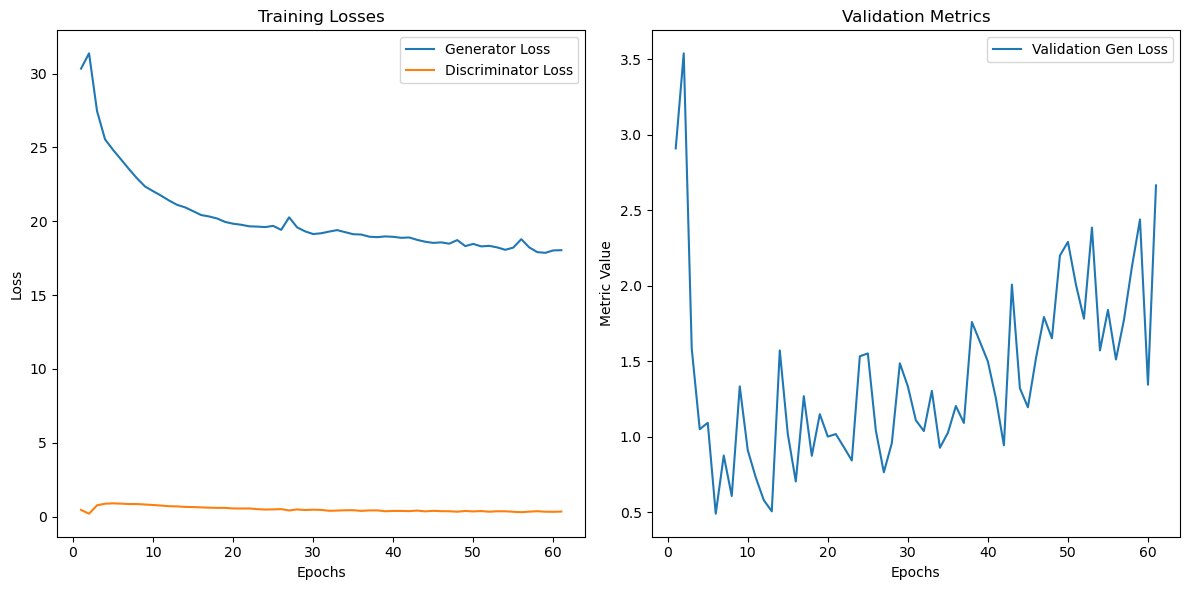

In [39]:
# Plot metrics
plt.figure(figsize=(12, 6))

# Plot Generator and Discriminator Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, gen_losses, label='Generator Loss')
plt.plot(epochs_list, disc_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

# Plot Validation Metrics
plt.subplot(1, 2, 2)
plt.plot(epochs_list, val_gen_losses, label='Validation Gen Loss')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Validation Metrics')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
epochs_list = np.array(epochs_list)

In [45]:
from sklearn.linear_model import LinearRegression
# Fit a linear regression model
model = LinearRegression()
model.fit(epochs_list, val_rmses)
trend_line = model.predict(epochs_list)

plt.figure(figsize=(12, 6))

# Plot validation RMSE values
plt.plot(epochs_list, val_rmses, label='Validation Gen Loss')

# Plot the trend line
plt.plot(epochs_list, trend_line, color='red', linestyle='--', label='Trend Line')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE with Trend Line')
plt.legend()

plt.tight_layout()
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

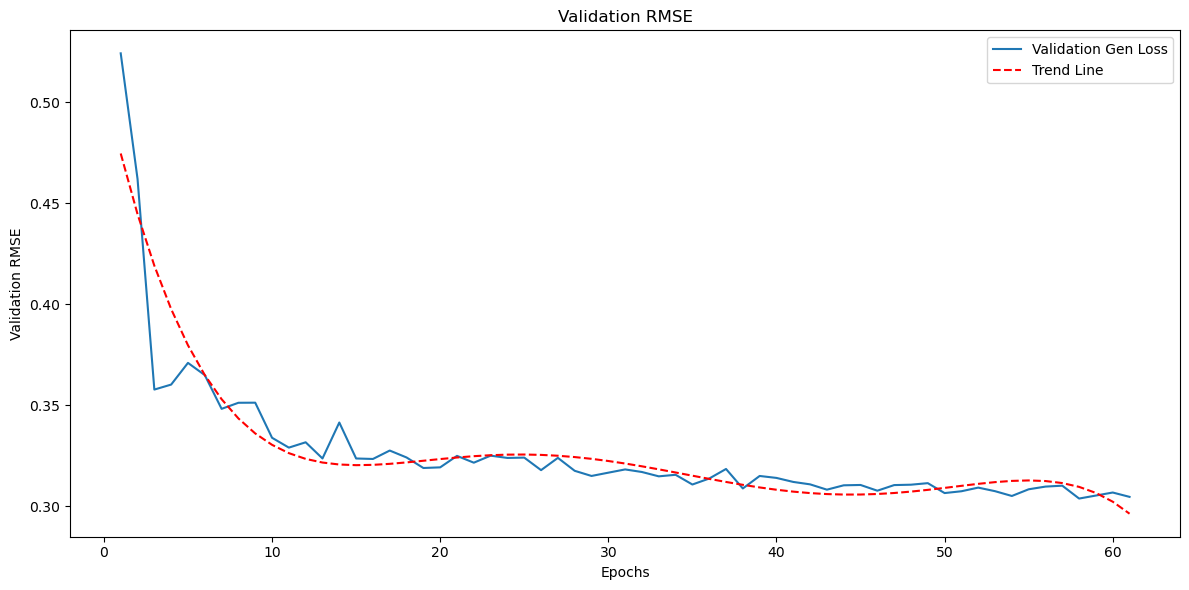

In [64]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Example data
epochs_list = np.array(epochs_list).reshape(-1, 1)  # 61 epochs reshaped for sklearn
# Fit a polynomial regression model (degree 2 for quadratic curve)
poly_features = PolynomialFeatures(degree=5)
epochs_poly = poly_features.fit_transform(epochs_list)
model = LinearRegression()
model.fit(epochs_poly, val_rmses)
trend_line = model.predict(epochs_poly)

plt.figure(figsize=(12, 6))

# Plot validation RMSE values
plt.plot(epochs_list, val_rmses, label='Validation Gen Loss')

# Plot the trend line
plt.plot(epochs_list, trend_line, color='red', linestyle='--', label='Trend Line')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE')
plt.legend()

plt.tight_layout()
plt.show()


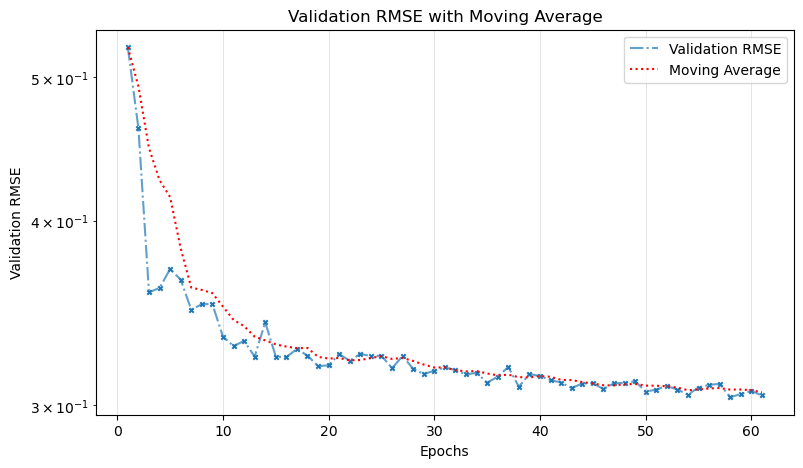

In [107]:
# Calculate moving average using pandas
window_size = 5
val_rmses_series = pd.Series(val_rmses)
moving_avg = val_rmses_series.rolling(window=window_size, min_periods=1).mean()
plt.figure(figsize=(9, 5))

# Plot validation RMSE values
plt.plot(epochs_list, val_rmses, label='Validation RMSE', alpha=0.7, linestyle='dashdot')
plt.scatter(epochs_list, val_rmses, s=10, marker='x')

# Plot the moving average
plt.plot(epochs_list, moving_avg, color='red', linestyle=':', label='Moving Average')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Add grid
plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE with Moving Average')
plt.legend()

2024-07-25 20:46:39.665788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 112 of 125
2024-07-25 20:46:40.803551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


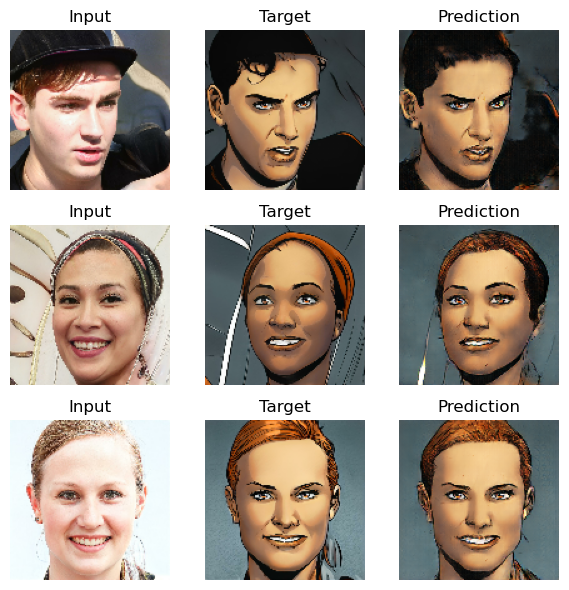

In [34]:
def display_random_images(val_dataset, generator_model, num_samples=3):
    # Get a random batch from the validation dataset
    val_dataset = val_dataset.shuffle(buffer_size=len(val_dataset))
    iterator = iter(val_dataset)

    # Collect a few random samples
    input_images = []
    target_images = []
    predicted_images = []

    for _ in range(num_samples):
        batch = next(iterator)
        input_image, target_image = batch
        input_images.append(input_image.numpy()[0])
        target_images.append(target_image.numpy()[0])
        predicted_image = generator_model(input_image, training=False)
        predicted_images.append(predicted_image.numpy()[0])

    # Plot the images
    fig, axes = plt.subplots(num_samples, 3, figsize=(num_samples*2, num_samples*2))

    for i in range(num_samples):
        # Input image
        axes[i, 0].imshow((input_images[i] + 1) / 2)  # Normalize for display
        axes[i, 0].set_title("Input")
        axes[i, 0].axis('off')

        # Target image
        axes[i, 1].imshow((target_images[i] + 1) / 2)  # Normalize for display
        axes[i, 1].set_title("Target")
        axes[i, 1].axis('off')

        # Predicted image
        axes[i, 2].imshow((predicted_images[i] + 1) / 2)  # Normalize for display
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
display_random_images(val_dataset, generator_model, num_samples=3)

In [35]:
generator_model.save("models/generator.tf")

INFO:tensorflow:Assets written to: models/generator.tf/assets


INFO:tensorflow:Assets written to: models/generator.tf/assets


In [36]:
discriminator_model.save("models/discriminator.tf")

INFO:tensorflow:Assets written to: models/discriminator.tf/assets


INFO:tensorflow:Assets written to: models/discriminator.tf/assets
